# Sqrt-biased sampling

This blog post accompanies the following article:
* Tim Vieira. 2016. [Sqrt-biased sampling](http://timvieira.github.io/blog/post/2016/06/28/sqrt-biased-sampling/).

**Setup**: For a given distribution `p` design a proposal distribution `q` to minimze the cost `c`, whcih is measure as the number of samples from `q` to find a sample from `p`.

```python
  # sample z
  z ~ p
  # sample from q until we get z
  i ~ q
  c = 1
  while i != z:
      i ~ q
      c += 1    # accumulate cost
```

It turns out, rather surprisingly, that the optimal choice for `q` is not `p`. It's actually `q ∝ sqrt(p)`.

### Monte Carlo simulation

In [69]:
def simulate(p, q, seed):
    with restore_random_state(seed):   # so that we can use common random numbers
        [n] = p.shape
        z = sample(p)   # Sample z from p
        i = sample(q)   # Propose i from q 
        c = 1
        while i != z:   # ... until we hit z
            i = sample(q)    # try again
            c += 1
        return c

### Analytic form

The analytic form for the expected number of samples

In [65]:
def analytic(p,q):
    return np.sum(p / q)

## Test cases

### Test simulation against analytical form

Test that the expected number of samples matches the analytical expression on some randomly generated distributions.

In [66]:
import numpy as np, pylab as pl, scipy as sp, scipy.stats
from arsenal.iterview import iterview
from arsenal.maths import restore_random_state, random_dist, sample, mean_confidence_interval
from numpy import sqrt

def test_expect_samples(n=10, R=20000):
    """
    Check that our expression for expected number of samples matches the Monte Carlo
    simulation (`simulate`).
    """

    p = random_dist(n)
    q = random_dist(n)

    cs = []
    for r in range(R):
        c = simulate(p, q, seed = r)
        cs.append(c)

    print(f'analytic: {analytic(p, q):.3f}')

    estimate, L, U = mean_confidence_interval(cs)
    print('estimate: %.3f ([%.3f, %.3f], n=%s)' % (estimate, L, U, len(cs)))
    assert L <= analytic(p, q) <= U

test_expect_samples()

analytic: 73.819
estimate: 75.520 ([69.970, 81.070], n=20000)


### Test one-dimensional proposal optimization

Compare the expected number of samples for $q \propto p^\alpha$ for several values of $\alpha$. Show the analytical curve and the simulation-based curve.

100.0% (20/20) [======================================================] 00:00:10


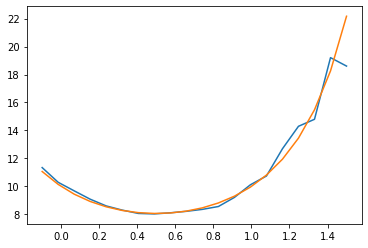

In [42]:
def compare_proposals(n=10, R=5000):
    "Compare proposal distributions"

    # Generate P's upfront so we have paired samples for the experiments
    # that follow. This reduces variance in the comparison.

    # uniform over probability simplex
    P = random_dist(R, n)    # R x n

    data = []
    for a in iterview(np.linspace(-.1, 1.5, 20)):

        analytical = 0.0; empirical = 0.0
        for i in range(R):
            p = P[i]
            q = p**a; q /= q.sum()    # annealed proposal distribution

            empirical += simulate(p, q, seed = i) / R
            analytical += analytic(p, q) / R

        data.append((a, [empirical, analytical]))

    xs, ys = list(zip(*data))
    pl.plot(xs, ys)
    pl.show()

compare_proposals()

### Test multi-dimensional proposal optimization

Test the we've correctly minimized the analytical expected number of samples wrt `q`.

In [67]:
from arsenal.maths import softmax
from scipy.optimize import minimize

def test_optimization(n=10):
    p = random_dist(n)
    
    # Minimize with numerical optimization. 
    #   Implementation note: we're using the softmax parameterization of a distribution 
    #   to avoid handling the constraint that q is in the simplex.
    sol = minimize(lambda w: np.sum(p/softmax(w)), x0 = np.zeros(n))

    # Recover q from the softmax parameterization
    got = softmax(sol.x)
    
    # The analytically optimal proposal
    want = p**0.5 / np.sum(p**0.5)
    
    err = np.abs(got - want).sum()
    assert err < 1e-5, err
    print('error:', err)

test_optimization()

error: 5.800968911652549e-07
